In [1]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg, minimize
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from hirax_transfer import core
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot, Scatterplot, index_find
from decimal import Decimal
from operator import add,sub
import scipy as sp
from cora.util import hputil
from astropy.stats import gaussian_fwhm_to_sigma
from hirax_transfer.beams import separations
import healpy as hp
from cora.core import skysim
from cora.foreground import gaussianfg, galaxy
from cora.util import coord
from drift.core import visibility
sys.path.insert(0,'/home/zahra/hirax_tools/')
from hirax_tools import array_config

In [2]:
m=manager.ProductManager.from_config('/home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/prod_params_custom.yaml')

correlation_arr, _, _, arranged_corr_unique_bls_lengths, _ = Bls_counts(m)

t=m.telescope
Nfeeds,_=t.feedpositions.shape
Ndish=Nfeeds/2
Nbls=Ndish*(Ndish-1)/2
antspos = t.feedpositions[:Ndish]
x=t.feedpositions[:,0] #these are x and y positions not x and y polarizations
y=t.feedpositions[:,1]


Product directory: /home/zahra/PIPELINE/example_5by5_kl_nodishscatter_lmax_200/bt_matrices


In [3]:
runs=10
time_channel=400
sigma = 0.001
sky = 1.

In [4]:
src=np.zeros(2*Nbls)
#src=src.reshape([1,2*Nbls]) 

In [5]:
lmax = t.lmax
mmax = t.mmax
nside = 128
print nside
angpos = hputil.ang_positions(nside)
zenith = t.zenith #same as np.radians(120)
frequencies = t.frequencies
print zenith
print angpos

128
[2.0943951 0.       ]
[[0.00637889 0.78539816]
 [0.00637889 2.35619449]
 [0.00637889 3.92699082]
 ...
 [3.13521376 2.35619449]
 [3.13521376 3.92699082]
 [3.13521376 5.49778714]]


In [6]:
wavelength = (3.e8)/(frequencies[0]*10.**6)
fwhm = 1.*wavelength/6.
sigma_beam = gaussian_fwhm_to_sigma*fwhm
seps = separations(angpos, zenith)
beammodel = np.exp(-seps**2/2/sigma_beam**2)
print beammodel

[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 1.21457520e-192
 1.21457520e-192 2.30466285e-189]


In [7]:
sph_arr = coord.sph_to_cart(angpos)
uhatc, vhatc = visibility.uv_plane_cart(zenith)


In [8]:
HAC = array_config.HIRAXArrayConfig.from_n_elem_compact(Ndish, 6.)


#uv = np.resize(np.repeat(3, sph_arr.shape[0]),(3, )
#print uv.shape

vis_all = np.array([])
#fringes_all = np.array([])

for i in correlation_arr:
    dish_0, dish_1 = i
    bl_ind = [np.int(dish_0), np.int(dish_1)]
    #v_coord, u_coord, _ = HAC.uvw_coords(frequencies[0],bl_ind)
    u_coord = (x[bl_ind[0]] - x[bl_ind[1]])/wavelength
    v_coord = (y[bl_ind[0]] - y[bl_ind[1]])/wavelength
    uv = u_coord * uhatc + v_coord * vhatc
    #print np.inner(sph_arr[0], uv), 'print '
    #print np.exp(np.inner(sph_arr[0], uv)), 'exp'
    fringes_ind = np.exp(1j*2*np.pi*np.sum(np.inner(np.abs(sph_arr), np.abs(uv))))
    vis_ind = np.sum(beammodel**2*fringes_ind*sky)
    vis_all = np.append(vis_all, np.round(vis_ind, 3))
    #fringes_all = np.append(fringes_all, fringes_ind)

In [9]:
vis_ = vis_all

vis_new = np.zeros(300, dtype= 'complex')
vis_new[:188] += vis_[:188]

vis_new[188:196] += vis_[188:196]
vis_new[196:204] += vis_[204:212]
vis_new[204:212] += vis_[196:204]
vis_new[212:220] += vis_[212:220]

vis_new[220:226] += vis_[220:226]
vis_new[226:232] += vis_[232:238]
vis_new[232:238] += vis_[226:232]
vis_new[238:244] += vis_[238:244]

vis_new[244:254] += vis_[244:254]

vis_new[254:258] += vis_[254:258]
vis_new[258:262] += vis_[262:266]
vis_new[262:266] += vis_[258:262]
vis_new[266:270] += vis_[266:270]

vis_new[270:274] += vis_[270:274]
vis_new[274:278] += vis_[274:278]

vis_new[278:281] += vis_[278:281]
vis_new[281:284] += vis_[284:287]
vis_new[284:287] += vis_[281:284]
vis_new[287:290] += vis_[287:290]

vis_new[290:292] += vis_[290:292]
vis_new[292:294] += vis_[294:296]
vis_new[294:296] += vis_[292:294]
vis_new[296:298] += vis_[296:298]

vis_new[298:299] += vis_[298:299]
vis_new[299:300] += vis_[299:300]


In [10]:
arranged_corr_counts = np.load('arranged_corr_counts_5by5_24_red_blocks.npy')
lims = np.append(0, np.cumsum(arranged_corr_counts))

arranged_corr_unique_bls = np.load('arranged_corr_unique_bls_5by5_24_red_blocks.npy')
correlation_arr = np.load('corr_arr_5by5_24_red_blocks.npy')

In [11]:
ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)


In [12]:
Cov_dic ={} # dictionary of expected of the sky covariance matrices for all redundant blocks at observing frequency


for ubl_k in range(len(lims)-1):
    block_k = arranged_corr_counts[ubl_k]
    cov_k =np.zeros((block_k,block_k), dtype='complex') 
    vis_block = vis_new[lims[ubl_k]:lims[ubl_k+1]]
    for bl_w in range(block_k):
        for bl_z in range(block_k):
            #print bl_z, 'blz'
            cov_k[bl_w][bl_z] = vis_block[bl_w]*vis_block[bl_z]  
    Cov_dic[ubl_k]= cov_k


In [13]:
nvec=4
vecs = np.zeros((2*300,2*nvec))
thresh = 1.e-34

for i in range(len(lims)-1):
    myeig, myvecs=np.linalg.eig(Cov_dic[i])
    ind = (np.abs(myeig)).argsort()[::-1][:nvec] #np.abs(myeig)>thresh*np.abs(myeig.max()) # picking up an index
    #myeig_use=myeig[ind] # pict max eigenvalue
    #myvecs_use=myvecs[:,ind] # pick  corresponding max eigenvec
    for j in range(len(ind)): #was previously range(len(myvecs_use))
            myvecs[:,ind[j]]= myvecs[:,ind[j]]*np.sqrt(myeig[ind[j]])
            vecs[2*lims[i]:2*lims[i+1]:2,2*j]=  np.column_stack(myvecs[:,ind[j]].real)
            vecs[(2*lims[i]+1):2*lims[i+1]:2,2*j+1]= np.column_stack(myvecs[:,ind[j]].imag)
vecs = vecs.T

In [14]:
v1=np.zeros(2*Nbls)
v1[0::2]=1
v2=np.zeros(2*Nbls)
v2[1::2]=1
#vecs=np.vstack([v1,v2])*1.e3

In [15]:
random_pt1=np.load('random_pt1.npy')*1.e-4
#random_pt1 = np.random.rand(1.e-7)



sim_gains = np.ones(2*Ndish) 
sim_gains[1::2]=0.

def fit_gains(m,random,sigma):
       
    gg=np.zeros((runs,Ndish*2))
    for ind_run in range(runs):
        print ind_run
        #vis=arr[0][:,time_channel]
        mu = 0 
        N_real=np.random.normal(mu, sigma, Nbls)
        N_imag=np.random.normal(mu, sigma, Nbls)
        N_comp=np.array([])
        for i in range(len(N_real)):
            N_comp=np.append(N_comp,complex(N_real[i],N_imag[i]))
        vis=vis_new+N_comp

        diag=sigma**2*np.ones(2*Nbls)
        print (sigma)
        mat=corrcal2.sparse_2level(diag,vecs,src,2*lims) #init
        mult=random+1.

        gvec=np.array([])
        for i in range(len(sim_gains)):
            gvec=np.append(gvec,sim_gains[i]+random[i])
            #gvec=np.append(gvec,random[i])
            #gvec=np.append(gvec,sim_gains[i]*mult[i])


        data=np.zeros(2*vis.size)
        data[0::2]=vis.real
        data[1::2]=vis.imag
        fac=1.;
        normfac=1.
        asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
        #asdf=fmin_cg(corrcal2.get_chisq_dense,gvec*fac,corrcal2.get_gradient_dense,(data,diag_mat,vecs_mat,ant1,ant2,fac,normfac))
        fit_gains_run=asdf/fac
        gg[ind_run,:]=fit_gains_run
        print fit_gains_run[::2]
    return gg
 
gg_2, sim_gains_amp_2 =fit_gains(m,random_pt1,sigma), sim_gains[::2]   
gg_2.shape


0
0.001
         Current function value: 641.446738
         Iterations: 4
         Function evaluations: 92
         Gradient evaluations: 81
[0.99999357 0.99999872 0.99999722 0.99999635 0.99999737 0.99999728
 0.99999487 0.99999086 0.99999347 0.99999761 0.99998889 0.99999696
 0.99999799 1.00000186 0.99999338 0.9999979  0.99999869 0.99999912
 1.00000118 0.9999956  0.99999375 0.9999941  0.99999786 0.99999076
 0.99999435]
1
0.001
         Current function value: 511.326286
         Iterations: 4
         Function evaluations: 53
         Gradient evaluations: 42
[0.9999992  0.99999572 0.99999203 0.99999861 0.99999518 0.99999398
 1.00000035 0.99999329 0.99999396 0.99999389 1.00000086 0.99999852
 0.99999604 0.99999806 0.99999597 0.99999609 1.0000039  0.99999195
 0.99999734 0.99999458 0.99999367 0.99999828 0.99999023 0.99999229
 0.99999569]
2
0.001
         Current function value: 595.857188
         Iterations: 6
         Function evaluations: 53
         Gradient evaluations: 30
[0.999993

(10, 50)

In [16]:

gg_corrcal, sim_gains_corrcal = gg_2, sim_gains_amp_2

def gains_mean_and_rel_err(gg,sim_gains_amp):
    gain_std=(np.std(gg,axis=0)/np.sqrt(runs)).flatten()
    gain_mean=np.mean(gg,axis=0).flatten() #shape is 98, we take every second one for amp so shape is 49
    rec_gains_mean_amp=gain_mean[0::2]
    rec_gains_std_amp=gain_std[0::2]
    rel_err_amp=np.abs(rec_gains_mean_amp-sim_gains_amp)/sim_gains_amp

    rel_err_amp_mean=np.mean(rel_err_amp)
    rel_err_amp_std=np.std(rel_err_amp,ddof=1)
    return rec_gains_mean_amp, rec_gains_std_amp, rel_err_amp, rel_err_amp_mean, rel_err_amp_std

rec_gains_mean_amp_2,_,rel_err_amp_2, rel_err_amp_mean_2 ,rel_err_amp_std_2 = gains_mean_and_rel_err(gg_corrcal, sim_gains_corrcal)

print rel_err_amp_std_2, rel_err_amp_mean_2

9.293890970080207e-07 4.01222265282275e-06


Text(0.5,1,'Averaged recovered gains vs simulated gains')

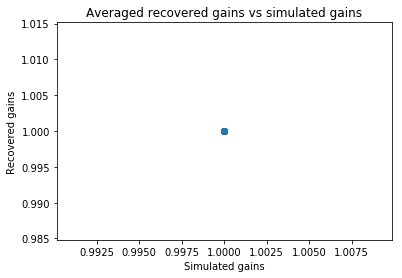

In [17]:
fig, ax = plt.subplots()

ax.scatter(sim_gains_amp_2, rec_gains_mean_amp_2)
#ax.plot(lims, lims,'g')
#plt.errorbar(x_true_real[:Ndish,time_channel],x_rec_real[:Ndish,time_channel],xerr=None,yerr=error[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
lim=.002
#plt.ylim(0.978,0.982)
plt.title('Averaged recovered gains vs simulated gains')
#plt.ylim(0.998,1.002)
#plt.savefig('avgd_recgains_vs_simgains_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_1e-4_initguess')


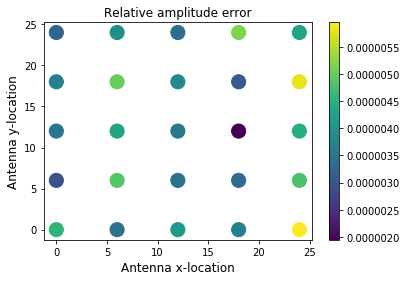

In [18]:
colour_scatterplot(m,rel_err_amp_2)

In [19]:
print rec_gains_mean_amp_2.min(), rec_gains_mean_amp_2.max()

0.9999940467357235 0.9999980542976393


In [20]:
def hist_rel_err_mean_std(gg,sim_gains_amp):
    gg_amp=gg[:,0::2]
    rel_error=np.abs((gg_amp-sim_gains_amp))/sim_gains_amp
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean

def hist_rel_err_mean_std_logcal(gg,sim_gains_amp):
    gg_amp=gg
    rel_error=np.abs((gg_amp-sim_gains_amp))/(sim_gains_amp) # remember to input exponent of both fit and simulated gains
    gg_amp_mean=np.mean(rel_error,axis=1) #shape is number of runs
    gg_amp_std=np.std(rel_error,axis=1,ddof=1)
    return gg_amp_std, gg_amp_mean


In [21]:
#np.save('std_fg_no_scatter_100runs_tsys_5',hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[0])

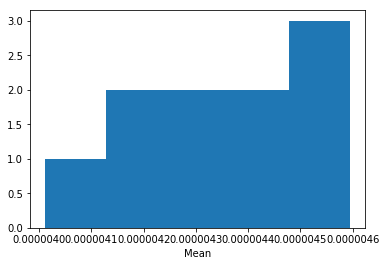

In [22]:
plt.hist(hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[1],'auto') 
plt.xlabel('Mean')
#plt.savefig('std_hist_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4')
plt.show()

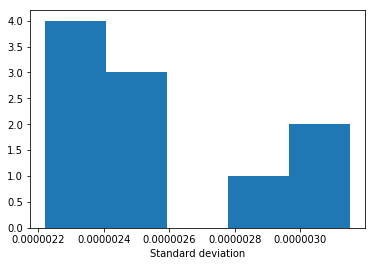

In [23]:
plt.hist(hist_rel_err_mean_std(gg_2,sim_gains_amp_2)[0],'auto') 
#plt.hist(std_fg, 'auto',color='b')
#plt.hist(std_no_sky_cov, 'auto', color='r')
plt.xlabel('Standard deviation')
#plt.xlim(0.0025,0.02)
#plt.savefig('std_hist_corrcal_5by5_nogainfluc_Tsys_50_no_dish_scatter_initguess_1e-4')
plt.show()